In [64]:
#2023 ECG AI challenge
#https://maic.or.kr/
"""
# 제공되는 데이터 셋은 약 44,000개(성인 35,141개, 소아 8,781개)로 이루어져 있습니다. npy 형식:(각각 5000x12 크기의 배열)
1. 성인 35,141개, 소아 8,781
2. category/ train /valid total
   adult    아직확인못함 /4375
   child 7342/1100   
   
"""

'\n# 제공되는 데이터 셋은 약 44,000개(성인 35,141개, 소아 8,781개)로 이루어져 있습니다.\n1. 성인 35,141개, 소아 8,781\n2. category train valid\n   adult\n   child\n   \n\n'

In [74]:
# library
import json
import torch
import os
from tqdm import tqdm
from resnet import ResNet1d
from dataloader import BatchDataloader
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

In [29]:
directory_path='/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input'
import os
for dirname, _, filenames in os.walk(directory_path):  #디렉토리 변경
    for filename in filenames:
        print(os.path.join(dirname, filename))

/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_adult_age_train.csv
/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_adult_numpy_valid.zip
/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_age_train.csv
/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_numpy_valid.zip
/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/submission.csv
/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_numpy_valid/ecg_child_8781.npy
/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_numpy_valid/ecg_child_8782.npy
/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_numpy_valid/ecg_child_8783.npy
/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_numpy_valid/ecg_child_8784.npy
/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/E

legth: 8781
결측치: FILENAME    0
GENDER      0
AGE         0
dtype: int64
중복된 값의 개수: 0
summary:                AGE
count  8781.000000
mean      2.168157
std       1.944972
min       0.083333
25%       0.583333
50%       1.250000
75%       3.750000
max       8.083333
MALE       4854
FEMALE     3926
unknown       1
Name: GENDER, dtype: int64


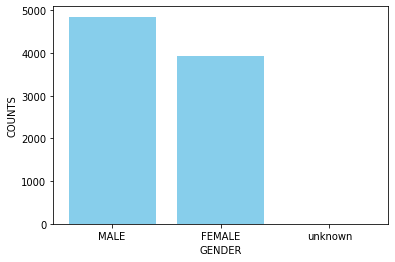

(array([5124., 1244.,  986., 1293.,  134.]),
 array([0.08333333, 1.68333333, 3.28333333, 4.88333333, 6.48333333,
        8.08333333]),
 <BarContainer object of 5 artists>)

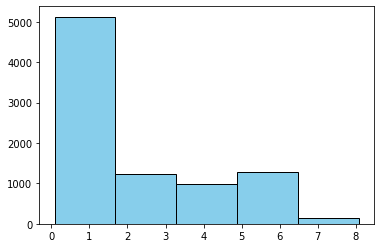

In [28]:
# %% Read datasets
# Get two group data
df1= pd.read_csv('/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_age_train.csv')
#df1= pd.read_csv('/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_adult_age_train.csv')

#print(df1.head())

print('legth:',len(df1))

print('결측치:', df1.isna().sum())

# '아이디' 컬럼의 중복된 값 개수 확인
duplicates_count = df1['FILENAME'].duplicated().sum()
print("중복된 값의 개수:", duplicates_count)

#summary
print('summary:', df1.describe())

category_counts=df1['GENDER'].value_counts()
print(df1['GENDER'].value_counts())

# barplot
plt.bar(category_counts.index, category_counts.values, color='skyblue')
plt.xlabel('GENDER')
plt.ylabel('COUNTS')
plt.show()


# histigram
plt.hist(df1['AGE'], bins=5, color='skyblue', edgecolor='black')


'/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input' 디렉토리 내의 파일 개수: 4375
File 1: ecg_adult_35141.npy
File 2: ecg_adult_35142.npy
File 3: ecg_adult_35143.npy
File 4: ecg_adult_35144.npy
File 5: ecg_adult_35145.npy
(60000,)
[86.  86.  86.  ...  6.   4.5  7.5]
0번째 인덱스의 값: 86.0


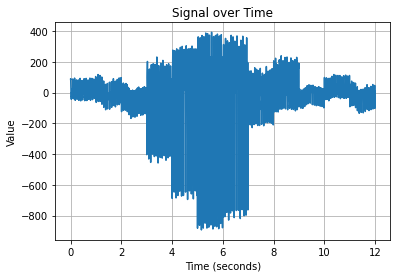

(60000,)이 아닌 shape의 개수: 0


In [63]:
#directory file confirm : ECG_adult_numpy_valid  #4375
# 파일이 들어 있는 디렉토리 경로 설정
dataset_path = '/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_adult_numpy_valid'
file_count = sum(len(files) for _, _, files in os.walk(dataset_path))
print(f"'{directory_path}' 디렉토리 내의 파일 개수: {file_count}")

# 앞 부분 몇 개의 파일 출력
num_files_to_display = 5  # 출력할 파일 개수 설정
[print(f"File {i + 1}: {file_name}") for i, file_name in enumerate(os.listdir(dataset_path)[:num_files_to_display])]

#예제 파일 살펴보기
data=np.load(os.path.join(dataset_path, 'ecg_adult_35141.npy'))
print(data.shape)   #(60000,)
print(data)


# 0번째 인덱스의 값 읽기
value_at_index_0 = data[0]
print(f"0번째 인덱스의 값: {value_at_index_0}")


#그래프로 그리기
sampling_rate = 5000  # 1초에 5000개의 점을 찍음
duration = len(data) / sampling_rate  # 데이터의 전체 기간 계산

# x 축 (시간) 설정
time = np.linspace(0, duration, len(data))

# 그래프 그리기
plt.plot(time, data)
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.title('Signal over Time')
plt.grid(True)

# 그래프 표시
plt.show()

# 디렉토리 내의 .npy 파일 목록 가져오기
npy_files = [file for file in os.listdir(dataset_path) if file.endswith('.npy')]

# (50000,)이 아닌 shape의 개수 세기
non_60000_shapes = sum(1 for file in npy_files if np.load(os.path.join(dataset_path, file)).shape != (60000,))
print(f"(60000,)이 아닌 shape의 개수: {non_60000_shapes}")

In [72]:
# (60000,) 배열을 (5000, 12) 형태로 재구성
data=np.load(os.path.join(dataset_path, 'ecg_adult_35141.npy'))
reshaped_data = data.reshape(5000, 12)
print(reshaped_data)

[[  86.    86.    86.  ...   86.    84.    82. ]
 [  80.    78.    76.  ...   70.    70.    70. ]
 [  72.    72.    72.  ...   68.    66.    64. ]
 ...
 [-100.   -99.   -93.  ...  -67.5  -61.5  -54.5]
 [ -49.5  -44.   -34.5 ...   -7.5   -4.    -0.5]
 [   5.     6.     4.  ...    6.     4.5    7.5]]


'/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input' 디렉토리 내의 파일 개수: 7342
File 1: ecg_child_2293.npy
File 2: ecg_child_2294.npy
File 3: ecg_child_2295.npy
File 4: ecg_child_2296.npy
File 5: ecg_child_2297.npy
(60000,)
[-24. -24. -24. ... -83. -81. -82.]
0번째 인덱스의 값: -24.0


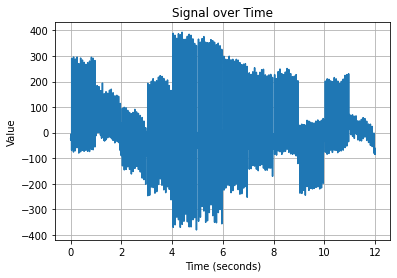

(60000,)이 아닌 shape의 개수: 0


In [58]:
#directory file confirm : ECG_child_numpy_train  # 7343
# 파일이 들어 있는 디렉토리 경로 설정
dataset_path = '/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_numpy_train'
file_count = sum(len(files) for _, _, files in os.walk(dataset_path))
print(f"'{directory_path}' 디렉토리 내의 파일 개수: {file_count}")

# 앞 부분 몇 개의 파일 출력
num_files_to_display = 5  # 출력할 파일 개수 설정
[print(f"File {i + 1}: {file_name}") for i, file_name in enumerate(os.listdir(dataset_path)[:num_files_to_display])]


#예제 파일 살펴보기
data=np.load(os.path.join(dataset_path, 'ecg_child_2293.npy'))
print(data.shape)   #(60000,)
print(data)
# 0번째 인덱스의 값 읽기
value_at_index_0 = data[0]
print(f"0번째 인덱스의 값: {value_at_index_0}")


#그래프로 그리기
sampling_rate = 5000  # 1초에 5000개의 점을 찍음
duration = len(data) / sampling_rate  # 데이터의 전체 기간 계산

# x 축 (시간) 설정
time = np.linspace(0, duration, len(data))

# 그래프 그리기
plt.plot(time, data)
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.title('Signal over Time')
plt.grid(True)

# 그래프 표시
plt.show()

# 디렉토리 내의 .npy 파일 목록 가져오기
npy_files = [file for file in os.listdir(dataset_path) if file.endswith('.npy')]

# (50000,)이 아닌 shape의 개수 세기
non_60000_shapes = sum(1 for file in npy_files if np.load(os.path.join(dataset_path, file)).shape != (60000,))
print(f"(60000,)이 아닌 shape의 개수: {non_60000_shapes}")

'/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input' 디렉토리 내의 파일 개수: 1100
[ -2.   -2.   -2.  ... -21.  -20.5 -20.5]
0
0번째 인덱스의 값: -2.0


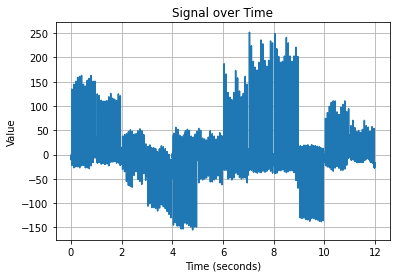

(60000,)이 아닌 shape의 개수: 0


In [49]:
#directory file confirm : ECG_child_numpy_valid
# 파일이 들어 있는 디렉토리 경로 설정
dataset_path = '/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_numpy_valid'
file_count = sum(len(files) for _, _, files in os.walk(dataset_path))
print(f"'{directory_path}' 디렉토리 내의 파일 개수: {file_count}")

#예제
data=np.load(os.path.join(dataset_path, 'ecg_child_9880.npy'))
data.shape   #(60000,)
print(data)
print(next((i for i, x in enumerate(os.path.join(dataset_path, 'ecg_child_9880.npy')) if x != -2.), None))
# 0번째 인덱스의 값 읽기
value_at_index_0 = data[0]

print(f"0번째 인덱스의 값: {value_at_index_0}")


#그래프로 그리기
sampling_rate = 5000  # 1초에 5000개의 점을 찍음
duration = len(data) / sampling_rate  # 데이터의 전체 기간 계산

# x 축 (시간) 설정
time = np.linspace(0, duration, len(data))

# 그래프 그리기
plt.plot(time, data)
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.title('Signal over Time')
plt.grid(True)

# 그래프 표시
plt.show()


# 디렉토리 내의 .npy 파일 목록 가져오기
npy_files = [file for file in os.listdir(dataset_path) if file.endswith('.npy')]

# (50000,)이 아닌 shape의 개수 세기
non_60000_shapes = sum(1 for file in npy_files if np.load(os.path.join(dataset_path, file)).shape != (60000,))
print(f"(60000,)이 아닌 shape의 개수: {non_60000_shapes}")

In [33]:
#directory file confirm
# 파일이 들어 있는 디렉토리 경로 설정
dataset_path = '/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input/ECG_child_numpy_train'
file_count = sum(len(files) for _, _, files in os.walk(dataset_path))
print(f"'{directory_path}' 디렉토리 내의 파일 개수: {file_count}")

'/home/work/ecg-age-prediction/ecg-age-prediction-main/competition/input' 디렉토리 내의 파일 개수: 1
